# Some ECG signal data sets
MIT-BIH cardiac arrythmia dataset to get started.
https://www.physionet.org/content/mitdb/1.0.0/

The signals were digitized @ 360 samples per second 11-bit resolution over a 10 mV range.

MIT-BIH Atrial Fibrilation data set
https://physionet.org/content/afdb/1.0.0/#files-panel

qtdb ecg database
https://physionet.org/content/qtdb/1.0.0/

This thing is becoming an annotation tool for a text + image + signals model.

Things implemented
1. signal reader
2. RR interval estimator
3. Notes on prompt engineering given time features -- this data set notes the medications that the patient was taking in the notes. Thats valuable as context.

Need to implement
1. QT interval estimator
2. State machine for P, QRS, or T wave. or something to segment this
3. Something to detect the switch to AFIB -- or predict likelihood of AFIB occuring.
4. Should be simple --  some plt.savefig() lines so that we can feed images and text to GPT and Gemini and the other multimodal huggingface llms


In [1]:
# this gives access to your whole drive and google account
# dont put anything in here that youre not using to code
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# wfdb stands for waveform database - use it for reading physiological signals
# documentation is available @ https://wfdb.readthedocs.io/en/latest/wfdb.html
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [3]:
# do the imports
import os
import glob
import wfdb
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal as scisig
from scipy.signal import medfilt


Number of files  12
signal shape  (650000, 2)
field keys  dict_keys(['fs', 'sig_len', 'n_sig', 'base_date', 'base_time', 'units', 'sig_name', 'comments'])
signal array  [[-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.35 ]
 [-0.115 -0.355]]
fields dictionary  {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['84 F 1633 1629 x1', 'Digoxin, Quinidine', 'The episodes of paroxysmal atrial flutter/fibrillation are usually', 'followed by nodal escape beats.  There are several intervals of', 'high-frequency noise/artifact in both channels.']}


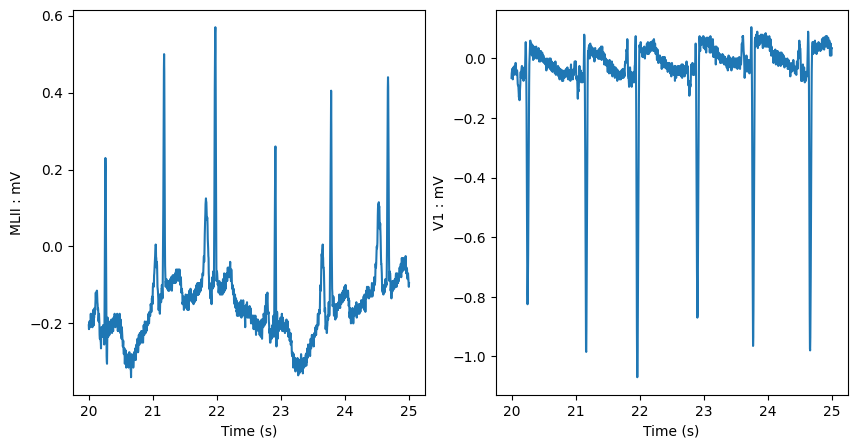

In [4]:
def Plot_signals(signals, fields, T1 = 20, t_win = 5, fs= 320):
  T2 = t_win + T1
  time_ = np.linspace(T1,T2, t_win*fs)

  fig, axes = plt.subplots(1,2, figsize=(10, 5))
  for i in range(2):
    axes[i].plot(time_, signals[T1*fs:T2*fs,i])
    axes[i].set_xlabel('Time (s)')
    # so signame here is the lead -- the view across the heart that this signal
    # gives us.
    axes[i].set_ylabel(fields['sig_name'][i] + ' : '+fields['units'][i])

def MIT_BIH_reader(SigNumber = -3):
  # first pass
  hdir = '/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/'
  # get all the file names from the data set
  hea = sorted(glob.glob(os.path.join(hdir,'*.hea')))
  hea = [hh.replace('.hea','') for hh in hea]

  # wfdb does not need the extension - it figures all that out apparently
  print('Number of files ', len(hea))


  # wfdb get signals
  signals, fields = wfdb.rdsamp(hea[SigNumber], )
  # print(type(signals))
  # print(type(fields))

  # signals is a numpy array, and fields is a dict
  print('signal shape ', signals.shape)
  print('field keys ', fields.keys())

  # print the array real quick
  print('signal array ', signals[0:10,:]) # signal
  print('fields dictionary ', fields) # notes about the signals

  # Note that the signals were digitized @ 360 samples per second
  # 11-bit resolution over a 10 mV range. so if you want
  fs = fields['fs'] # sampling frequency - should be 360

  # signal is already in milivolts ok.
  # plotting

  Plot_signals(signals, fields, T1 = 20, t_win = 5, fs= 320)
  return signals, fields


signals_, fields_ = MIT_BIH_reader(SigNumber = -3)



---
Now we have something that can just open signal files. we probably want some denoising stuff first. Then we can start setting windows around the different peaks. -- Peak detection with old fashioned AI approahces.  

---



In [5]:
plt.close('all')

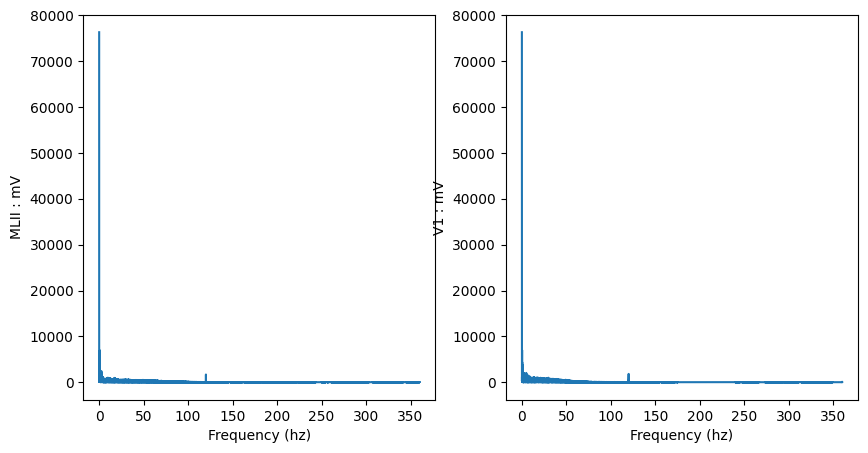

In [6]:
# signal to noise estimate right.
def MagSpectPlotter(signals_, fields_):
  signals_ = signals_ - np.mean(signals_)
  samps = int(signals_.shape[0]/2)

  spect = np.fft.fft(signals_, axis = 0,) # fast fourier transform
  mag = np.abs(spect) # magnitude at each frequency
  freqs = np.linspace(0, fields_['fs'], samps) # frequency axis

  fig, axes = plt.subplots(1,2, figsize=(10, 5))
  for i in range(2):
    axes[i].plot(freqs, mag[0:samps, i])
    axes[i].set_xlabel('Frequency (hz)')
    # # so signame here is the lead -- the view across the heart that this signal
    # # gives us.
    axes[i].set_ylabel(fields_['sig_name'][i] + ' : '+fields_['units'][i])

  plt.show()

MagSpectPlotter(signals_, fields_)

working 


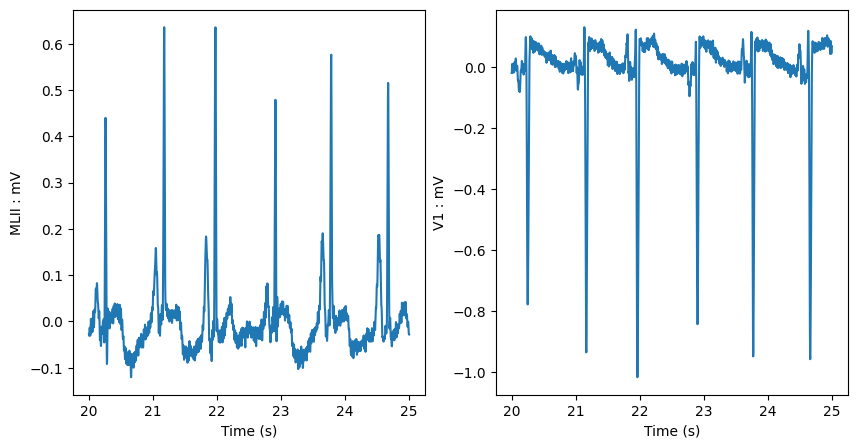

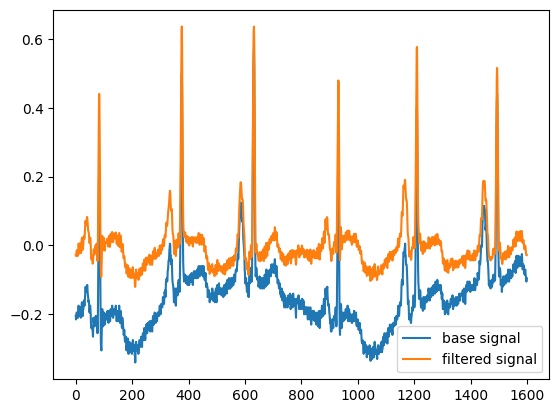

In [7]:
# program signal denoising and interval detectors here.
def NoiseReduction(signals_, fields_, T1 = 1, t_win = 5, fs= 320):
    fs = 0+fields_['fs']
    T2 = t_win + T1
    time_ = np.linspace(T1,T2, t_win*fs)
    print('working ')
    # parameters for initial band pass filtering
    cut_args={
              'smp_rate' : fs, # sampling rate
              'lp_pass' : 80, # low pass filter pass band
              'lp_stop' : 90, # low pas filter stop band
              'hp_pass' : 0.75, # high pass filter pass band
              'hp_stop' : 0.01, # high pass filter stop band
              'sb_att' : 210, # stop band attenuation
             }
    # leaving filter design components in place
    nyq_rate = cut_args['smp_rate']/2
    lbord,lwn = scisig.cheb2ord(wp = cut_args['lp_pass']/nyq_rate, ws =cut_args['lp_stop']/nyq_rate, gpass = .1, gstop = cut_args['sb_att'])
    # High pass filter stop at 0.1Hz, and pass at 1Hz
    hbord,hwn = scisig.cheb2ord(wp = cut_args['hp_pass']/nyq_rate, ws = cut_args['hp_stop']/nyq_rate, gpass = .1, gstop = cut_args['sb_att'])

    lb,la = scisig.cheby2(N = lbord, rs = cut_args['sb_att'], Wn = lwn,
                          btype = 'lowpass', output ='ba')

    hb,ha = scisig.cheby2(N = hbord, rs = cut_args['sb_att'], Wn = hwn,
                          btype = 'highpass', output ='ba')

    # right now we only get one signals
    fdat = scisig.filtfilt(lb, la, signals_, axis = 0)
    fdat = scisig.filtfilt(hb, ha, fdat, axis = 0)

    # plt.figure(figsize=(10, 5))

    # plt.plot(time_, signals_[fs*T1:fs*T2,0], label = 'base signal')
    # plt.plot(time_, fdat[fs*T1:fs*T2], label = 'cleaner signal')
    # plt.legend()
    # plt.show()
    return fdat

# now just rewrite this to dump the cleaner signal
filtered_data = NoiseReduction(signals_, fields_, T1 = 20)
Plot_signals(filtered_data, fields_, T1 = 20, t_win = 5, fs= 320)

plt.figure()
plt.plot(signals_[20*320:25*320,0], label = 'base signal')
plt.plot(filtered_data[20*320:25*320,0], label = 'filtered signal')
plt.legend()
plt.show()


# median filter and call it to get rid of the little noise peaks

In [8]:
plt.close('all')

(650000, 2)
mean signal :  0.0018199063007716674
RMS signal:  0.0881485055931385
R-R Intervals :  [[0.909375 0.8      0.940625 0.865625 0.890625]]
Average R-R Interval :  0.88125
Std R-R Interval :  0.047434164902525694


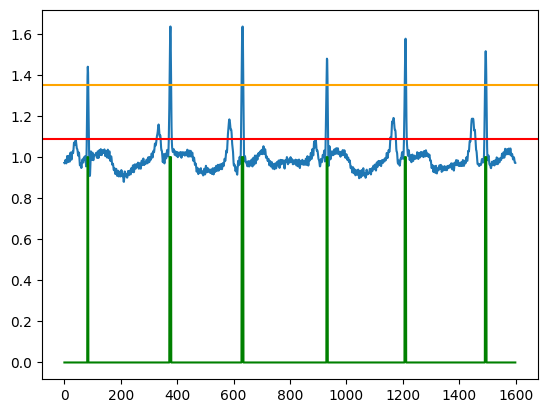

In [29]:
# put this into a function....
# savitzky-Golay filter is a moving average filter that has a polynomial
# approximation of the data. so it's good for smoothing. - data, window, polynomial
# smoothed_fdata = sp.signal.savgol_filter(filtered_data[0:320*5, 0],7,2,)

# so RMS threshold will pretty much reliably give you the P and R waves
def GetRRInterval(x, T0 = 0, T = 5, fs = 320, th = 3 ):
    # Easy but breakable version of this is to threshold wrt the rms signal
    win_filtered_data = x[T0*fs:T*fs]
    # some signals have inverted QRS, so I want to flip it if thats the case
    # R is a big peak so it'll weight the rest of the signal more negative
    mean_sig = np.mean(win_filtered_data)
    if mean_sig <0 :
      win_filtered_data = -1*win_filtered_data

    rms = np.sqrt(np.mean(np.square(win_filtered_data)))
    print('mean signal : ', mean_sig)
    print('RMS signal: ', rms)

    # threshold
    R_waves = (win_filtered_data > th*rms) +0
    left_edge = np.diff(R_waves) > 0

    # divide by 320 to get time in seconds.
    RR_intervals = np.diff(np.where((left_edge)+0 ==1)) /320

    print('R-R Intervals : ', RR_intervals)
    print('Average R-R Interval : ', np.mean(RR_intervals))
    print('Std R-R Interval : ', np.std(RR_intervals))

    # return an output dictionary so the number of outputs isnt so long
    output_object = {
        'win_filtered_data' : win_filtered_data,
        'RR_intervals' : RR_intervals,
        'R_waves' : R_waves,
        'rms' : rms,
        'th' : th,
    }
    return output_object

print(filtered_data.shape)
outputs = GetRRInterval(filtered_data[:,0], T0=20, T=25, th = 4)


# then you can take diff of R waves to get the left edge..

plt.figure()
plt.plot(outputs['win_filtered_data'] + 1)
plt.axhline(outputs['rms'] + 1, color = 'red')
plt.axhline(outputs['th']*outputs['rms'] + 1, color = 'orange')
plt.plot(outputs['R_waves'], 'g')


mean signal :  -0.00044460667127139487
RMS signal:  0.14616938821275013
R-R Intervals :  [[0.9125   0.796875 0.940625 0.86875  0.8875  ]]
Average R-R Interval :  0.88125
Std R-R Interval :  0.048613591206575144


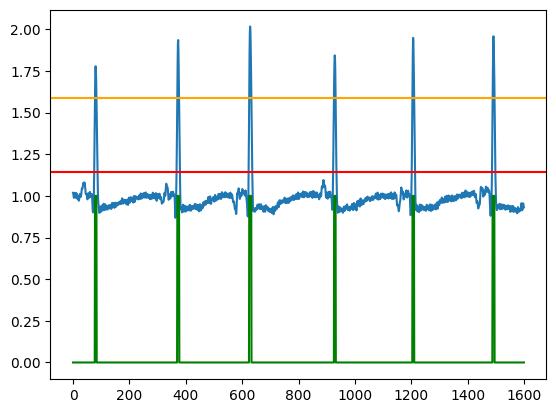

In [30]:

# the other veiw has an inverted QRS - so take absolute value to get it to work.
outputs_1 = GetRRInterval(filtered_data[:,1], T0=20, T=25, th = 4)
plt.figure()
plt.plot(outputs_1['win_filtered_data'] + 1)
plt.axhline(outputs_1['rms'] + 1, color = 'red')
plt.axhline(outputs_1['th']*outputs_1['rms'] + 1, color = 'orange')

plt.plot(outputs_1['R_waves'], 'g')

In [31]:
plt.close('all')

In [21]:
# Then here I want to make sure the fields all make sense for this signal.
print(fields_)

{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['84 F 1633 1629 x1', 'Digoxin, Quinidine', 'The episodes of paroxysmal atrial flutter/fibrillation are usually', 'followed by nodal escape beats.  There are several intervals of', 'high-frequency noise/artifact in both channels.']}


So now we have the R-R Interval. We can get average R-R Interval, and standard deviation for that window. We have a measure of heart rate variability. It's not *the measure of* heart rate variability but still related to it.

Once you get the R wave, you can make a window around the R wave find the max values- so the one on the left will be the P peak, and the one on the right will be the T peak. Compute intervals that way. Now in a real time situation you would not do this. you only assume you have past and present data. never future data. For this purpose you can assume the sensor is storing memory and making a desicion after the buffer is full since it is not a real time detection system.

Ok so now we have some signal cleaning. Next step is to start identifying the beat and the QT interval, RR interval. That stuff is useful.

In [ ]:
# want to know which files ha
def function2():
  # first pass
  hdir = '/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/'
  # get all the file names from the data set
  hea = sorted(glob.glob(os.path.join(hdir,'*.hea')))
  hea = [hh.replace('.hea','') for hh in hea]

  # wfdb does not need the extension - it figures all that out apparently
  print('Number of files ', len(hea))

  for SigNumber in range(len(hea)):
    print(hea[SigNumber])
    # wfdb get signals
    signals, fields = wfdb.rdsamp(hea[SigNumber], )
    print(fields)
function2()

*'sig_name': ['MLII', 'V5']*

MLII and V5 are views across the heart for the ECG leads. Meanwhile the comments look like they say, Age Sex start stop x1/x2, medications list, comments

*'comments': ['51 M 640 654 x2', 'Digoxin, Lasix, Pronestyl', 'The lower channel has low-amplitude high-frequency noise throughout.']*


# Asking ChatGPT5 about medications that patients were on in the study
What effects would we think Pronestyl would have on the heart?
---

ChatGPT5 responds with

---

Pronestyl is the brand name for procainamide, a Class Ia antiarrhythmic drug. Its main effects on the heart come from how it alters ion flow across cardiac cells:

Mechanism of Action

* Blocks fast sodium channels → slows depolarization in cardiac myocytes, which reduces conduction velocity.

* Prolongs action potential duration by also blocking some potassium channels → lengthens the refractory period.

* These actions reduce the ability of abnormal electrical circuits to sustain arrhythmias.

Expected Cardiac Effects

* Slows conduction through the atria, ventricles, and His-Purkinje system.

* Suppresses abnormal automaticity (ectopic pacemaker activity).

* Prolongs the QT interval on ECG because of delayed repolarization.

* Treats ventricular and supraventricular arrhythmias, including atrial fibrillation, atrial flutter, and ventricular tachycardia.

Potential Adverse Effects

* Arrhythmogenic risk: QT prolongation can lead to torsades de pointes.

* Negative inotropy: can decrease contractility, especially in compromised hearts.

* Hypotension: more common with IV use due to vasodilation.

* Long-term use: can cause a lupus-like syndrome.

👉 In short: Pronestyl slows conduction, prolongs refractory periods, and can help stop arrhythmias—but it carries risks of QT prolongation and reduced pumping strength.

Would you like me to sketch out how this would look on an ECG before vs. after Pronestyl (e.g., widened QRS, prolonged QT)?


# Some other prompts to programatically ask of text models
What you want to get out of this prompt is a numercial measure you can use to supplement the Arrhythmia detector with down the line.

## A. General effects
What effects on the heart would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual?

## B. A + include ECG view
What effects on the *[view]* ECG signal would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual?

## C. B + include arrythmia detection
What effects on the *[view]* ECG signal would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual? How would this impact an algorithm that does arrhythmia detection?

## D. C + include methodology for arrhythmia detection
What effects on the *[view]* ECG signal would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual? How would this impact the R-R interval portion of an algorithm that detects arrhythmias?


## Formatted text
You could load some text like this. Like JSON format. Then ask the questions about outcome

Age: 69

Gender: M

Average RR-Interval: 0.9s

Std RR-Interval: 0.25s

Average QT-Interval: 0.2s

Std QT-Interval: 0.25s

Heart rate : 60 BPM

Medications : pronestyl

Dietary notes : high fat diet


Think about using this model for the visual question answering task.
https://huggingface.co/google/pix2struct-chartqa-base





In [ ]:
# # import transformers
# from transformers import BertTokenizer, BertForMaskedLM